In [49]:
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import RandomizedSearchCV, RepeatedStratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
import sklearn2pmml as pmml
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn_porter import Porter                   # Custom - edited to work with python3.9
import pandas as pd
from pathlib import Path
from functools import reduce

from exploration_helper import time_frame_optimization, build_resampled_df

# Kontextsensitive Systeme - Modellfindung

Im folgenden wird der Data-Science Prozess zur Modellfindung für das KSS Projekt durchgeführt.

Die Schritte hierzu umfassen:
- *Resampling*
- *Feature Engineering & Feature Importance Ranking*
- *Evaluation & Hyperparameteroptimierung der Classifier*
- *Evaluation von Klassifikationsmodellen*

Zunächst werden die einzelnen Schritt detailliert anhand von Decision Trees untersucht. Im Anschluss erfolgt eine  weniger detaillierte Evaluation verschiedener Modelle inkl. Parameter-Optimierung. Dies weicht natürlich leicht von der best practice Methode ab, da *alle* Schritte mit allen Modellen gegeneinander evaluiert werden könnten. Dies sprengt jedoch den Rahmen dieser Arbeit.

### Random State

Wir beginnen mit dem Erstellen eines Random States um die Ergebnisse reproduizierbar zu machen.

In [81]:
state = np.random.RandomState(seed=6517619) # Decimal Representation of UTF encoded "CSS" :)

## Data Cleaning/Preparation

Als nächstes werden die Daten aus .csv Dateien importiert und in eine entsprechende Form in einem pd.DataFrame gebracht. Es ergeben sich 6 Spalten an Sensordaten. Es werden Daten zu Orientierung und Beschleunigung verwendet.

In [82]:
dfs = []
filenames = {
    "Accelerometer.csv": {
        "z": "acc_z", 
        "y": "acc_y", 
        "x": "acc_x", 
        "time": "time", 
        "seconds_elapsed": 
        "seconds_elapsed"
    },
    "Orientation.csv": {
        "yaw": "alpha",
        "roll": "gamma",
        "pitch": "beta"}
}

In [83]:
# Funktion zum lesen der .csv Dateien und umbenennen der Spalten nach Mappern s.o.
read = lambda file: pd \
                .read_csv(file, sep=",", header=0, parse_dates=True, infer_datetime_format=True)\
                .rename(columns=filenames[file.name])

In [100]:
# Aggregieren der dfs zu einem df
for folder in Path("data").iterdir():
    if folder.name.startswith("."):
        continue
    print("Reading", folder)
    session_dfs = [read(file) for file in folder.iterdir() if file.name in filenames]
    label = open(folder.joinpath("label.txt"), "r").readlines()[0]
    joint_session_df = reduce(lambda a, b: pd.merge(a, b, on=["time", "seconds_elapsed"]), session_dfs)
    joint_session_df.insert(0, "activity", label)
    dfs.append(joint_session_df)

db = reduce(lambda a, b: a.append(b), dfs)

Reading data/running-2022-02-02_16-21-13
Reading data/walking-2022-02-02_16-18-54
Reading data/walking_hand-2022-02-02_16-13-07
Reading data/walking-2022-02-02_16-23-01
Reading data/walking-2022-02-02_16-10-08
Reading data/pausing-2022-02-03_12-47-38
Reading data/running-2022-02-02_16-14-33


In [85]:
# Entfernen von überflüssigen Spalten
db["time"] = pd.to_datetime(db["time"])
db = db.set_index(["time"])
db = db.drop("seconds_elapsed", axis=1)

In [86]:
# Class mapping;
classes = {"pausing": 0, "running": 1}

# Entferne Quartenionen-Darstellung, da nicht (ohne weiteres) verfügbar im Browser
db_cleaned = db.drop(["qx", "qy", "qz", "qw"], axis=1)
db_cleaned["activity"] = db["activity"].apply(lambda x: classes[x])

**Der finale DataFrame mit "activity" als target sieht als aus wie folgt**

In [87]:
db_cleaned.head(10)

,activity,alpha,gamma,beta,acc_z,acc_y,acc_x
time,,,,,,,
2022-02-02 15:21:13.909253000,1,-2.033771,0.130994,0.336905,-0.630153,0.706151,-0.842766
2022-02-02 15:21:14.009160200,1,-2.020111,0.270677,0.487375,2.053477,-0.011665,-1.820781
2022-02-02 15:21:14.109067300,1,-1.923151,0.403944,0.643670,1.066186,1.520387,-1.365054
2022-02-02 15:21:14.208974000,1,-1.767503,0.578782,0.706169,-1.411229,-2.124124,1.525786
2022-02-02 15:21:14.308881200,1,-1.693327,0.681624,0.805902,-0.284351,-2.943029,4.360647
2022-02-02 15:21:14.408788000,1,-1.579551,0.739941,0.766680,-0.160599,0.745414,0.869923
2022-02-02 15:21:14.508694000,1,-1.437475,0.781497,0.682150,1.573859,3.380768,-0.898143
2022-02-02 15:21:14.608601000,1,-1.468877,1.151474,0.697441,1.938818,-2.674917,1.620770
2022-02-02 15:21:14.708508000,1,-1.345581,1.323490,0.857846,3.087629,-2.298619,5.652280


In [88]:
db_cleaned.describe()

,activity,alpha,gamma,beta,acc_z,acc_y,acc_x
count,7602.000000,7602.000000,7602.000000,7602.000000,7602.000000,7602.000000,7602.000000
mean,0.685083,0.072862,0.562862,-0.507144,-0.051726,0.926428,0.165966
std,0.464513,1.642563,1.440094,0.908706,5.964533,6.387426,8.165211
min,0.000000,-3.139352,-3.128817,-1.562032,-50.118665,-23.201862,-29.673974
25%,0.000000,-1.370323,-0.695914,-1.274529,-1.681740,-1.163179,-3.517932
50%,1.000000,0.192722,1.130581,-0.937540,-0.055578,0.004212,0.001933
75%,1.000000,1.455857,1.732150,0.198692,1.295951,1.932148,1.813757
max,1.000000,3.141416,3.140320,1.566586,75.023894,70.529365,71.919597


## Feature Engineering

Der folgende Abschnitt behandelt feature engineering. Auf die Sensordaten werden verschiedene Aggregationsfunktionen angewendet: *[Summe, Arithm. Mittel, Varianz, Minimum, Maximum]*.
Gleichzeitig, wird zur Optimierung eine Reihe von möglichen Timeframes herangezogen.

### Resampling

Das Sampling wurde aus technischen Gründen für alle features 10 Samples/s vorgenommen. Hier folgt ein resampling zur Optimimierung der Aktivitätserkenung. Die Frequenzen zum resampling finden sich unten.

### Ergebnisse des Resampling

Die verschiedenen Timeframes wurden in 200ms Schritten erhöht (ab 1000ms in 500ms).

Text(0.5, 1.0, 'Accuracy')

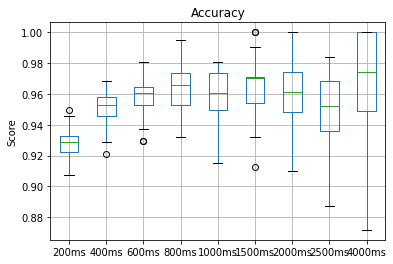

In [89]:
val_timeframes = ["200ms", "400ms", "600ms", "800ms", "1000ms", "1500ms", "2000ms", "2500ms", "4000ms"]

time_frame_optimization(db_cleaned, DecisionTreeClassifier(random_state=state), val_timeframes).boxplot()
plt.ylabel("Score")
plt.title("Accuracy")

Text(0.5, 1.0, 'F1-Score')

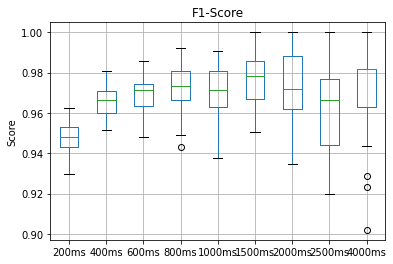

In [90]:
time_frame_optimization(db_cleaned, DecisionTreeClassifier(), val_timeframes, metric=f1_score).boxplot()
plt.ylabel("Score")
plt.title("F1-Score")

### Feature Importance

Als nächstes ein kurzer Einblick in die importance der verschiedenen features.

Dazu betrachten wir das absolute, standardisierte Verbesserung des Gini Koeffizienten durch das entspr. feature (Gini Importance).

<AxesSubplot:>

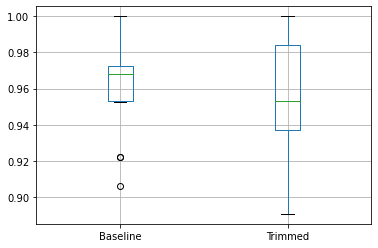

In [91]:
from exploration_helper import evaluate_feature_importance, time_frame_optimization

X_, y_ = build_resampled_df(db_cleaned, "600ms")
y_np = np.asarray(y_)


dt = DecisionTreeClassifier(random_state=state)

trimmed_feature_importance, trimmed_features = evaluate_feature_importance(dt, 0.01, X_, y_, random_state=state) #  0.01 seems to be a good value, formal evaluation possible, but plotting gets a bit messy
trimmed_feature_importance.boxplot()

In [92]:
trimmed_features

{'beta mean': 0.010752032965295463,
 'acc_z var': 0.8351606851927003,
 'acc_y var': 0.011585423707572987,
 'acc_x var': 0.07955096327754281}

In [93]:
X_trimmed = X_[trimmed_features]

# Klassifikation

Nun werden evaluieren wir eine Reihe von verschiedenen Klassifikations-Modellen.
Im folgenden betrachten wir
- Support Vector Machines
- Random Forests
- AdaBoost (DT)
- Decision Trees

Da einige Algorithmen (insb. SVMs) distanzbasierte Verfahren sind und daher sensitiv gegenüber Skalierung sind, skalieren wir die Daten auf eine N(0,1) Verteilung (z-Score). Tree-based Algorithmen sind weniger sensitiv ggü. Skalierung, der Vergleichbarkeit wegen, werden jedoch alle Algroithmen mit den skalierten Daten arbeiten.

In [94]:
X_scaled = StandardScaler().fit_transform(X_trimmed)

### SVM

SVMs haben eine Reihe von Hyperparametern die zu optimieren sind. Dazu gehören der Fehlerterm C, die Kernelfunktion mit ihrem Varianzparameter gamma und ggf. der Poylnomgrad, sofern der Polynom-Kernel gewählt wird.

Die gebrächlichsten Kernels sind der rbf, poly und sigmoid Kernel.

Im folgenden werden wir diese drei Kernels evaluieren. Für C und gamma nutzen wir eine Reihe von 10er Potenzen (siehe param dict). Die Kombinationen werden in einer GridSearch mit Cross-Validation geprüft.

In [95]:
params = {
    'C': [0.1,1, 10, 100],
    'gamma': [1,0.1,0.01,0.001],
    'kernel': ['rbf', 'poly', 'sigmoid'],
    'degree': [8]
}
svc = GridSearchCV(SVC(), params, refit=True, error_score=0.0, n_jobs=4)
svc.fit(X_scaled, y_)
best_svc =  svc.best_estimator_

[print(key, ":", svc.best_estimator_.__getattribute__(key)) for key in params]
pass

C : 100
gamma : 0.01
kernel : rbf
degree : 8


Für den AdaBoost Algorithmus, also DecisionTrees mit Boosting, verwenden wir eine Randomized Search für die Learning Rate. Die Learning rate gibt an, wie stark die Vorhersagen eines neues Models (Jede Runde wird ein neues Modell hinzugefügt) gewichtet wird.

In [97]:
params = {
    "learning_rate": state.uniform(0, 2, 20)
}

ada = RandomizedSearchCV(AdaBoostClassifier(), params, refit=True, error_score=0.0, n_jobs=4, random_state=state, cv=10)
ada.fit(X_scaled, y_)
best_ada = ada.best_estimator_

print("learning rate:", best_ada.__getattribute__("learning_rate"))

learning rate: 0.12036086467275098


Nun initialisieren wir die übrigen Vergleichsalgorithmen. Hier ist eine Hyperparameteroptimierung möglich, jedoch sind sie nicht ganz so essentiell wie bei SVC.
Als Baseline fügen wir noch einen Dummy classifier hinzu, der immer die häufigste Klasse im sample voraussagt.

In [98]:
rf = RandomForestClassifier(random_state=state)

dt = DecisionTreeClassifier(random_state=state)

major_class = DummyClassifier(random_state=state)

<AxesSubplot:xlabel='model', ylabel='value'>

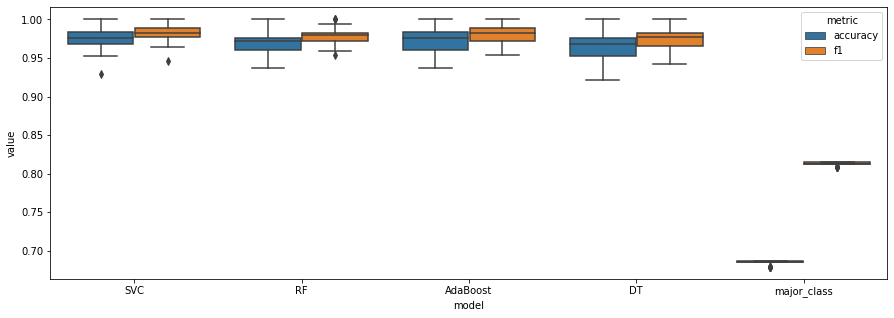

In [99]:
models = {"SVC": best_svc,"RF": rf,"AdaBoost": best_ada,"DT": dt, "major_class": major_class}
data = []
for train_idx, test_idx in RepeatedStratifiedKFold(n_splits=10, random_state=state).split(X_scaled, y_):
    for model_name in models.keys():
        X_train, X_test = X_scaled[train_idx, :], X_scaled[test_idx, :]
        y_train, y_test = y_[train_idx], y_[test_idx]
        models[model_name].fit(X_train, y_train)
        y_pred = models[model_name].predict(X_test)

        data.append([model_name, "accuracy", accuracy_score(y_test, y_pred)])
        data.append([model_name, "f1", f1_score(y_test, y_pred)])

values = pd.DataFrame(data, columns=["model", "metric","value"])
fig = plt.figure(figsize=(15, 5))
sns.boxplot(data=values, x="model", y="value", hue="metric")

## Export als .pmml

sklearn2pmml ermöglicht den Export von ganzen sklearn Pipelines. Um eine bessere performance zu erreichen, z.B. durch eine estprechende Skalierung, ist die Verwendung empfehlenswert.

In [ ]:
pl = pmml.PMMLPipeline([
    ('standardize', StandardScaler()),
    ('clf', RandomForestClassifier())
])
pl.fit(X_scaled, y_)
pmml.sklearn2pmml(pl, './pmml_file.pmml', with_repr=True)

## Export als js-Classifier mit sklean-porter

In [47]:
rf = RandomForestClassifier()
rf.fit(X_trimmed, y_)

s = Porter(rf, language="js").export(embed_data=True)
with open("rf.js", "w") as file:
    file.write(s)
    file.close()

/opt/homebrew/Caskroom/miniforge/base/envs/test/lib/python3.9/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: The attribute `n_features_` is deprecated in 1.0 and will be removed in 1.2. Use `n_features_in_` instead.
  warnings.warn(msg, category=FutureWarning)


In [48]:
dt = DecisionTreeClassifier()
dt.fit(X_trimmed, y_)

s = Porter(dt, language="js").export(embed_data=True)
with open("dt.js", "w") as file:
    file.write(s)
    file.close()

/opt/homebrew/Caskroom/miniforge/base/envs/test/lib/python3.9/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: The attribute `n_features_` is deprecated in 1.0 and will be removed in 1.2. Use `n_features_in_` instead.
  warnings.warn(msg, category=FutureWarning)
